# Исследование окупаемости рекламы

Вы — маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Ваша задача — разобраться в причинах и помочь компании выйти в плюс.


Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
* лог сервера с данными об их посещениях,
* выгрузка их покупок за этот период,
* рекламные расходы.

Нам предстоит изучить:
* откуда приходят пользователи и какими устройствами они пользуются,
* сколько стоит привлечение пользователей из различных рекламных каналов;
* сколько денег приносит каждый клиент,
* когда расходы на привлечение клиента окупаются,
* какие факторы мешают привлечению клиентов.

<a id='content'></a>
## Оглавление

### Открытие и предобработка данных 
* [Загрузка датасета и проверка его на наличие дубликатов, пропусков и соответствие типам данных, а также правильность выгрузки](#start)

### Исследовательский анализ данных
* [Рассмотрим профили пользователей](#part_1.1)
* [Вывод](#part_1.2)

### Построение отчетов и расчет метрик
* [Продукт](#part_2.1)
* [Продажи](#part_2.2)
* [Маркетинг](#part_2.3)

### Расчет и анализ LTV, ROI, удержания и конверсии
* [Проанализируем общую окупаемость рекламы](#part_3.1)
* [Проанализируем окупаемость рекламы с разбивкой по устройствам](#part_3.2)
* [Проанализируем окупаемость рекламы с разбивкой по странам](#part_3.3)
* [Проанализируем окупаемость рекламы с разбивкой по рекламным каналам](#part_3.4)

### Вывод
* [Сделаем общий вывод](#finish)

# Открытие и предобработка данных 
<a id='start'></a>
Загрузка датасета и проверка его на наличие дубликатов, пропусков и соответствие типам данных, а также правильность выгрузки

[*Назад к оглавлению*](#content)

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

visits, orders, costs = (
    pd.read_csv('/datasets/visits_info.csv'),  
    pd.read_csv('/datasets/orders_info.csv'),  
    pd.read_csv('/datasets/costs_info.csv'),  
)

In [2]:
visits.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,01.05.2019 02:36,01.05.2019 02:45
1,278965908054,United States,iPhone,organic,01.05.2019 04:46,01.05.2019 04:47
2,590706206550,United States,Mac,organic,01.05.2019 14:09,01.05.2019 15:32
3,326433527971,United States,Android,TipTop,01.05.2019 00:29,01.05.2019 00:54
4,349773784594,United States,Mac,organic,01.05.2019 03:33,01.05.2019 03:57


In [3]:
orders.head()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [4]:
costs.head()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


Посмотрим на наличие полных дубликатов.

In [5]:
visits.duplicated().sum()

0

In [6]:
orders.duplicated().sum()

0

In [7]:
costs.duplicated().sum()

0

Дубликатов нет - значит качество первоначальных данных достаточно хорошее.

Переименуем названия столбцов для облегчения дальнейшего взаимодействия и приведем даты к формату *datetime*.

In [8]:
visits.columns = ['user_id', 'region', 'device', 'channel', 'session_start', 'session_end']
orders.columns = ['user_id', 'event_dt', 'revenue']
costs.columns = ['dt', 'channel', 'costs']

visits['session_start'] = pd.to_datetime(visits['session_start'], format = '%d.%m.%Y %H:%M')
visits['session_end'] = pd.to_datetime(visits['session_end'], format = '%d.%m.%Y %H:%M')
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

In [9]:
    purchase = (
        orders.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg(
            {
                'event_dt': 'first',
            }
        )
        .rename(columns={'event_dt': 'first_purchase'})
        .reset_index()
    )
    
    purchase

,user_id,first_purchase
0,599326,2019-05-07 20:59:09
1,46006712,2019-06-30 03:46:52
2,374052872,2019-08-16 07:44:47
3,414791703,2019-05-04 18:06:41
4,785077127,2019-06-30 18:35:15
...,...,...
8876,999625937544,2019-10-26 06:24:27
8877,999645428220,2019-10-01 05:36:23
8878,999659859721,2019-09-08 01:28:08
8879,999779032958,2019-07-05 23:28:13


## Исследовательский анализ данных

[*Назад к оглавлению*](#content)

<a id='part_1.1'></a>
Построим профили пользователей. Определим минимальную и максимальную дату привлечения пользователей.

Выясним:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

Далее я пользуюсь функцией для создания пользовательских профилей, взятой с курса Я.Практикума.

In [11]:
profiles = get_profiles(visits, orders, costs)
profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost,first_purchase
0,599326,2019-05-07 20:58:00,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172,2019-05-07 20:59:09
1,4919697,2019-07-09 12:46:00,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237,NaT
2,6085896,2019-10-01 09:58:00,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000,NaT
3,22593348,2019-08-22 21:35:00,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235,NaT
4,31989216,2019-10-02 00:07:00,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769,NaT


Определим минимальную и максимальную даты привлечения пользователей

In [12]:
first_ts_min = profiles['first_ts'].dt.date.min()
first_ts_max = profiles['first_ts'].dt.date.max()
print(first_ts_min, first_ts_max)

2019-05-01 2019-10-27


Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [13]:
profiles_region = (
    profiles.groupby('region')
    .agg({'payer':['sum', 'mean']})
)
profiles_region.columns = ['payer_count', 'payer_part']
profiles_region.sort_values(by = 'payer_count', ascending=False)

,payer_count,payer_part
region,,
United States,6902.0,0.069019
UK,700.0,0.039829
France,663.0,0.037994
Germany,616.0,0.041119


Подавляющее большинство платящих пользователей приходит из США - 6902 клиента. Однако даже там часть платящих пользователей составляет лишь 6,9%.

Узнайем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [14]:
profiles_device = (
    profiles.groupby('device')
    .agg({'payer':['sum', 'mean']})
)
profiles_device.columns = ['payer_count', 'payer_part']
profiles_device.sort_values(by = 'payer_count', ascending=False)

,payer_count,payer_part
device,,
iPhone,3382.0,0.062079
Android,2050.0,0.058518
Mac,1912.0,0.063644
PC,1537.0,0.050468


В девайсах лидерами стад iPhone. Но тут разница между устройствами не так велика.

Больше всего платят пользователь Mac и iPhone.

Изучим рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [15]:
profiles_channel = (
    profiles.groupby('channel')
    .agg({'payer':['sum', 'mean']})
)
profiles_channel.columns = ['payer_count', 'payer_part']
profiles_channel.sort_values(by = 'payer_count', ascending=False)

,payer_count,payer_part
channel,,
FaceBoom,3557.0,0.122049
TipTop,1878.0,0.096007
organic,1160.0,0.020553
WahooNetBanner,453.0,0.052964
AdNonSense,440.0,0.113402
RocketSuperAds,352.0,0.079137
LeapBob,262.0,0.030633
OppleCreativeMedia,233.0,0.027077
lambdaMediaAds,225.0,0.104700


Уверенным лидером стал FaceBoom, там же и наибольший процент платящих пользователей - 12%.

### Вывод <a id='part_1.2'></a>

Первоначально можно сделать следующие выводы:
* Подавляющее большинство платящих пользователей приходит из США - 6902 клиента. Однако даже там часть платящих пользователей составляет лишь 6,9%.
* В девайсах лидером стао iPhone. Но тут разница между устройствами не так велика. Наибольшая доля платящих пользователей пользуются Mac и iPhone.
* По рекламным каналам уверенным лидером стал FaceBoom, там же и наибольший процент платящих пользователей - 12%.

В целом можно сказать, что процент платящих пользователь крайне мал, нужно разобраться, с чем это связано.

## Построение отчетов и расчет метрик

[*Назад к оглавлению*](#content)

Продукт:

-    Сколько людей пользуются в день, неделю, месяц?
-    Сколько сессий в день?
-    Сколько длится одна сессия?

Продажи:

- Когда люди начинают покупать?
- Сколько покупок делает в среднем платящий пользователь за месяц, неделю, день?
- Какой средний чек за месяц, неделю, день?

Маркетинг:

- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

### Продукт: <a id='part_2.1'></a>
-    Сколько людей пользуются в день, неделю, месяц?

Рассчитаем DAU, WAU и MAU

In [16]:
visits['session_year'] = visits['session_start'].dt.year
visits['session_month'] = visits['session_start'].dt.month
visits['session_week'] = visits['session_start'].dt.week
visits['session_date'] = visits['session_start'].dt.date


dau_total = (visits.groupby('session_date').agg({'user_id': 'nunique'}).mean())

wau_total = (
    visits.groupby(['session_year', 'session_week'])
    .agg({'user_id': 'nunique'})
    .mean()
)

mau_total = (
    visits.groupby(['session_year', 'session_month'])
    .agg({'user_id': 'nunique'})
    .mean()
)

print(dau_total, wau_total, mau_total)

user_id    1684.23913
dtype: float64 user_id    8353.777778
dtype: float64 user_id    28989.166667
dtype: float64


Отобразим изменения метрик во времени на графиках

Text(0.5, 1.0, 'Изменение числа пользователей за день')

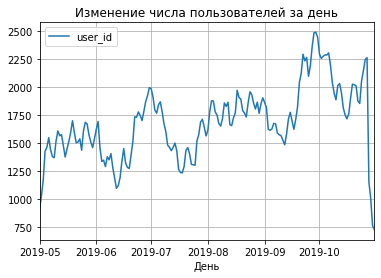

In [17]:
visits.groupby('session_date').agg({'user_id': 'nunique'}).plot(grid=True)
plt.xlabel('День')
plt.title('Изменение числа пользователей за день')

Text(0.5, 1.0, 'Изменение числа пользователей за неделю')

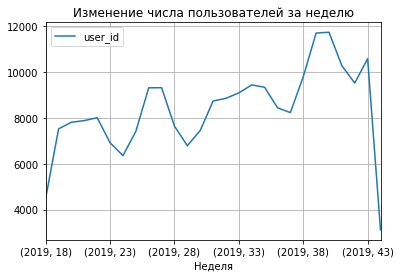

In [18]:
visits.groupby(['session_year', 'session_week']).agg({'user_id': 'nunique'}).plot(grid=True)
plt.xlabel('Неделя')
plt.title('Изменение числа пользователей за неделю')

Text(0.5, 1.0, 'Изменение числа пользователей за месяц')

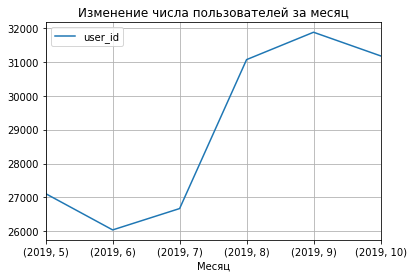

In [19]:
visits.groupby(['session_year', 'session_month']).agg({'user_id': 'nunique'}).plot(grid=True)
plt.xlabel('Месяц')
plt.title('Изменение числа пользователей за месяц')

-    Сколько сессий в день?

Изучим число пользовательских сессий в день

1682.0

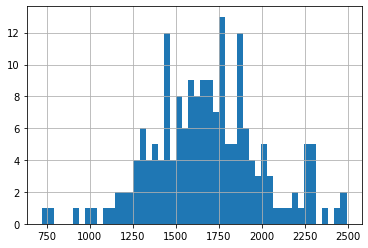

In [20]:
sessions = visits.groupby('session_date').agg({'user_id':'count'})
sessions.columns = ['n_sessions']
sessions['n_sessions'].hist(bins=50)
sessions['n_sessions'].median()

Медианное значение сессий в день - 1682

-    Сколько длится одна сессия?

count    309901.000000
mean       1800.084801
std        1803.189827
min           0.000000
25%         540.000000
50%        1260.000000
75%        2520.000000
max       22260.000000
Name: session_duration, dtype: float64

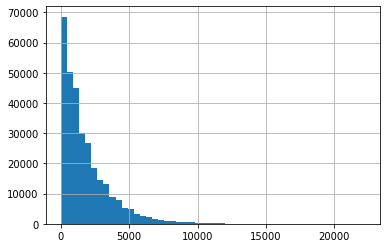

In [21]:
visits['session_duration'] = (visits['session_end'] - visits['session_start']).dt.seconds
visits['session_duration'].hist(bins=50)
visits['session_duration'].describe()

Можем сделать вывод, что в среднем сессии длились 21 минуту.

### Продажи: <a id='part_2.2'></a>

- Когда люди начинают покупать?

Исследуем, сколько времени в среднем проходит с момента первого посещения до покупки.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


70.0

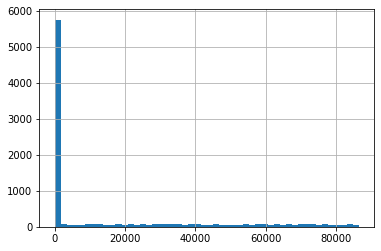

In [22]:
purchase = profiles.query('payer == True')
purchase['free_period'] = (purchase['first_purchase'] - purchase['first_ts']).dt.seconds
purchase['free_period'].hist(bins=50)
purchase['free_period'].median()

В основном клиенты совершали первую покупку через 70 секунд после первой сессии - неплохо!

- Сколько покупок делает в среднем платящий пользователь за месяц, неделю, день?

Рассчитаем среднее число покупок за день, неделю и месяц. Построим графики изменения этих метрик во времени.

In [23]:
orders['event_year'] = orders['event_dt'].dt.year
orders['event_month'] = orders['event_dt'].dt.month
orders['event_week'] = orders['event_dt'].dt.week
orders['event_date'] = orders['event_dt'].dt.date


day_purchase = (
    orders.groupby('event_date').agg({'user_id': 'count'}).mean()
)

week_purchase = (
    orders.groupby(['event_year', 'event_week'])
    .agg({'user_id': 'count'})
    .mean()
)

month_purchase = (
    orders.groupby(['event_year', 'event_month'])
    .agg({'user_id': 'count'})
    .mean()
)

print(day_purchase, week_purchase, month_purchase)

user_id    218.543478
dtype: float64 user_id    1489.333333
dtype: float64 user_id    6702.0
dtype: float64


Text(0.5, 1.0, 'Изменение числа покупок за день')

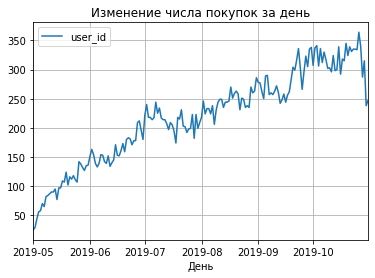

In [24]:
orders.groupby('event_date').agg({'user_id': 'count'}).plot(grid=True)
plt.xlabel('День')
plt.title('Изменение числа покупок за день')

Text(0.5, 1.0, 'Изменение числа покупок за неделю')

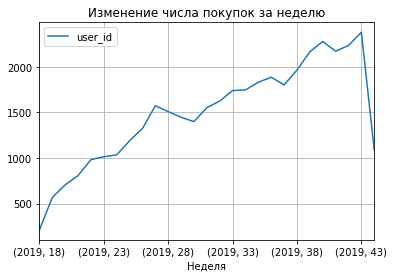

In [25]:
orders.groupby(['event_year', 'event_week']).agg({'user_id': 'count'}).plot(grid=True)
plt.xlabel('Неделя')
plt.title('Изменение числа покупок за неделю')

Text(0.5, 1.0, 'Изменение числа покупок за месяц')

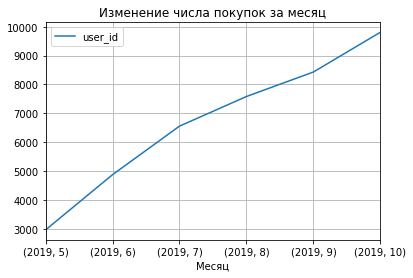

In [26]:
orders.groupby(['event_year', 'event_month']).agg({'user_id': 'count'}).plot(grid=True)
plt.xlabel('Месяц')
plt.title('Изменение числа покупок за месяц')

Число покупок уверенно растет со временем.

- Какой средний чек за месяц, неделю, день?

In [27]:
day_revenue = (
    orders.groupby('event_date').agg({'revenue': 'mean'}).mean()
)

week_revenue = (
    orders.groupby(['event_year', 'event_week'])
    .agg({'revenue': 'mean'})
    .mean()
)

month_revenue = (
    orders.groupby(['event_year', 'event_month'])
    .agg({'revenue': 'mean'})
    .mean()
)

print(day_revenue, week_revenue, month_revenue)

revenue    5.375884
dtype: float64 revenue    5.376336
dtype: float64 revenue    5.374169
dtype: float64


Text(0.5, 1.0, 'Изменение среднего чека за день')

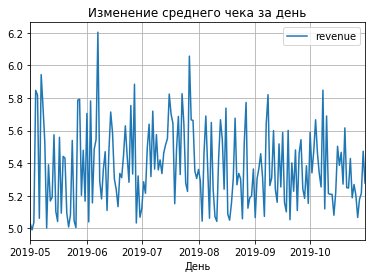

In [28]:
orders.groupby('event_date').agg({'revenue': 'mean'}).plot(grid=True)
plt.xlabel('День')
plt.title('Изменение среднего чека за день')

Text(0.5, 1.0, 'Изменение среднего чека за неделю')

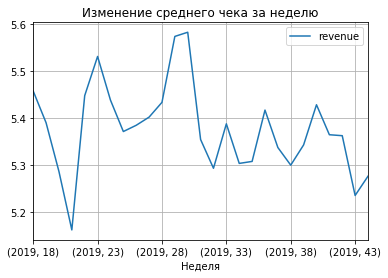

In [29]:
orders.groupby(['event_year', 'event_week']).agg({'revenue': 'mean'}).plot(grid=True)
plt.xlabel('Неделя')
plt.title('Изменение среднего чека за неделю')

Text(0.5, 1.0, 'Изменение среднего чека за месяц')

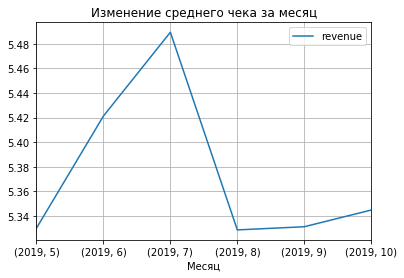

In [30]:
orders.groupby(['event_year', 'event_month']).agg({'revenue': 'mean'}).plot(grid=True)
plt.xlabel('Месяц')
plt.title('Изменение среднего чека за месяц')

Можем заметить, что средний чек меняется несущественно.

### Маркетинг: <a id='part_2.3'></a>

- Сколько денег потратили? Всего / на каждый источник / по времени

Посчитаем общую сумму расходов на маркетинг. Выясним, как траты распределены по источникам. Визуализируем изменения метрик во времени

In [31]:
costs['costs'].sum()

105497.30000000002

In [32]:
costs.groupby(['channel']).agg({'costs':'sum'}).sort_values(by='costs', ascending=False)

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


Text(0.5, 1.0, 'Изменение трат на рекламу за день')

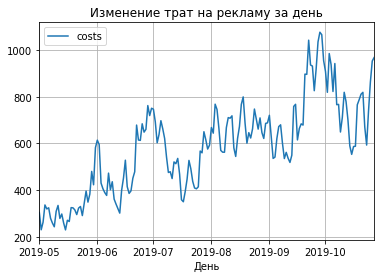

In [33]:
costs.groupby('dt').agg({'costs':'sum'}).plot(grid=True)
plt.xlabel('День')
plt.title('Изменение трат на рекламу за день')

Text(0.5, 1.0, 'Изменение трат на рекламу за день')

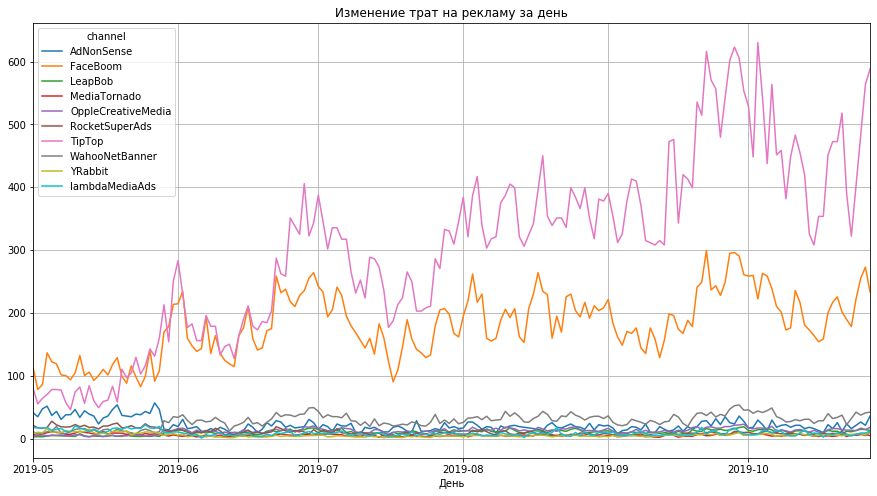

In [34]:
costs.pivot_table(index='dt', columns='channel', values='costs', aggfunc='sum').plot(grid=True, figsize=(15,8))
plt.xlabel('День')
plt.title('Изменение трат на рекламу за день')

Можем заметить, что с течением времени траты на маркетинг росли, но это касалось только TipTop и FaceBoom, остальные канали привлечения стабильны.

- Сколько в среднем стоило привлечение одного пользователя из каждого источника?

In [35]:
costs['costs'].sum() / visits['user_id'].nunique()

0.703277825182657

In [36]:
profiles.groupby('channel').agg({'acquisition_cost' : 'mean'}).sort_values(by='acquisition_cost', ascending=False)

,acquisition_cost
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


В среднем привлечение одного пользователя обходилось в 0,7. Однако пользователи, привлеченные через рекламу в TipTop, FaceBoom и AdNonSense дороже, их привлечение стоило 2,8, 1,11 и 1,0 соответственно.

## Расчет и анализ LTV, ROI, удержания и конверсии

[*Назад к оглавлению*](#content)

Далее будут использоваться функции для расчета и анализа LTV, ROI, удержания и конверсии из курса Я.Практикума. Так как они были написаны не мной, а также являются интеллектуальной собственностью Я.Практикума, я приведу только результаты анализа.

In [44]:
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14
profiles_filtred = profiles.query('channel != "organic"')

### Проанализируем общую окупаемость рекламы <a id='part_3.1'></a>

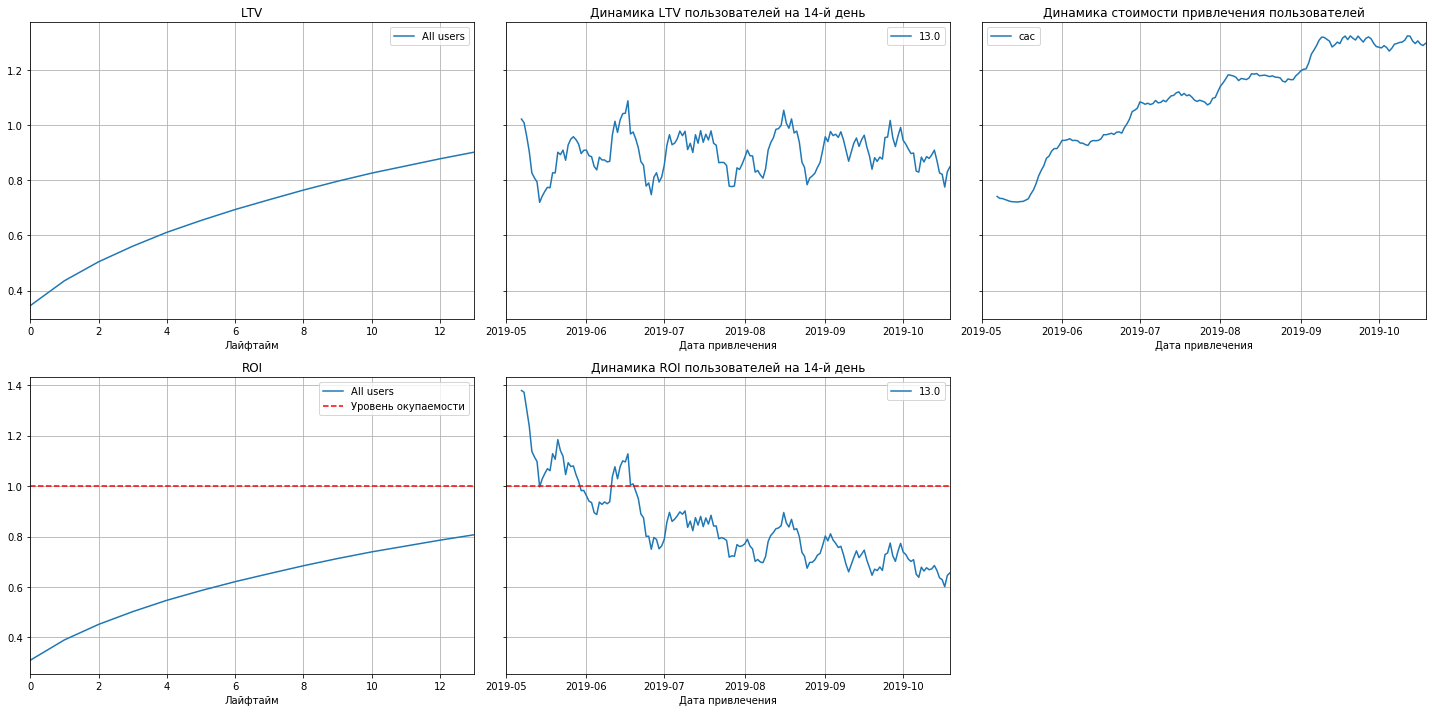

In [45]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_filtred, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

По графикам можно сделать такие выводы:
* Реклама не окупается. ROI в конце второй недели недели - только 80%.
* CAC растет. Компания увеличивает рекламный бюджета.
* На LTV влияет сезонный фактор, но и этот показатель достаточно стабилен. Значит, дело не в ухудшении качества пользователей.
* Динамика ROI снижается - сказывается увеличение затрат на рекламу.

### Проанализируем окупаемость рекламы с разбивкой по устройствам <a id='part_3.2'></a>

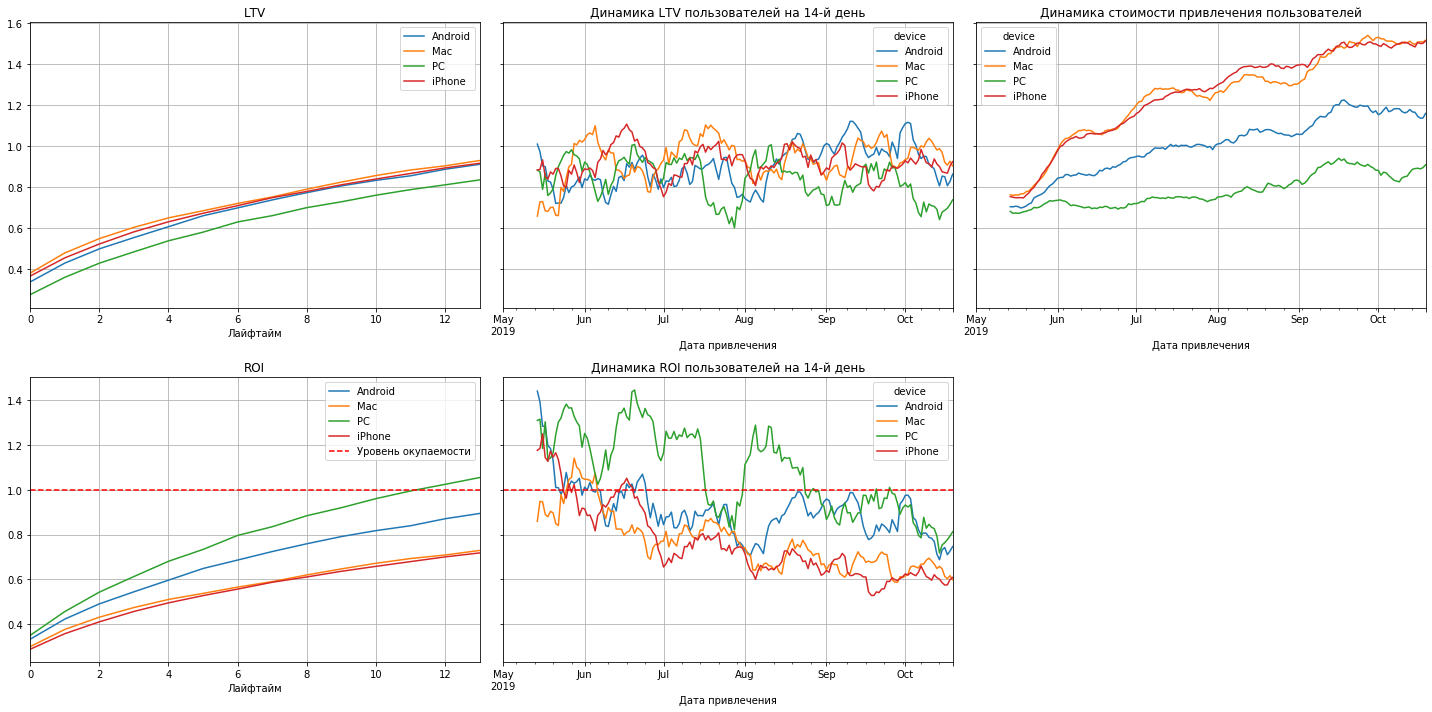

In [46]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_filtred, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

По графикам можно сделать такие выводы:
* Стоимость привлечения растет а всех устройствах. Сильнее всего на iPhone и MAC.
* Окупается только PC, на 12 день. Далее идет Android - к концу срока он окупается лишь на 90%. iPhone и MAC к концу 14 дня окупаются только на 70%.

### Проанализируем окупаемость рекламы с разбивкой по странам <a id='part_3.3'></a>

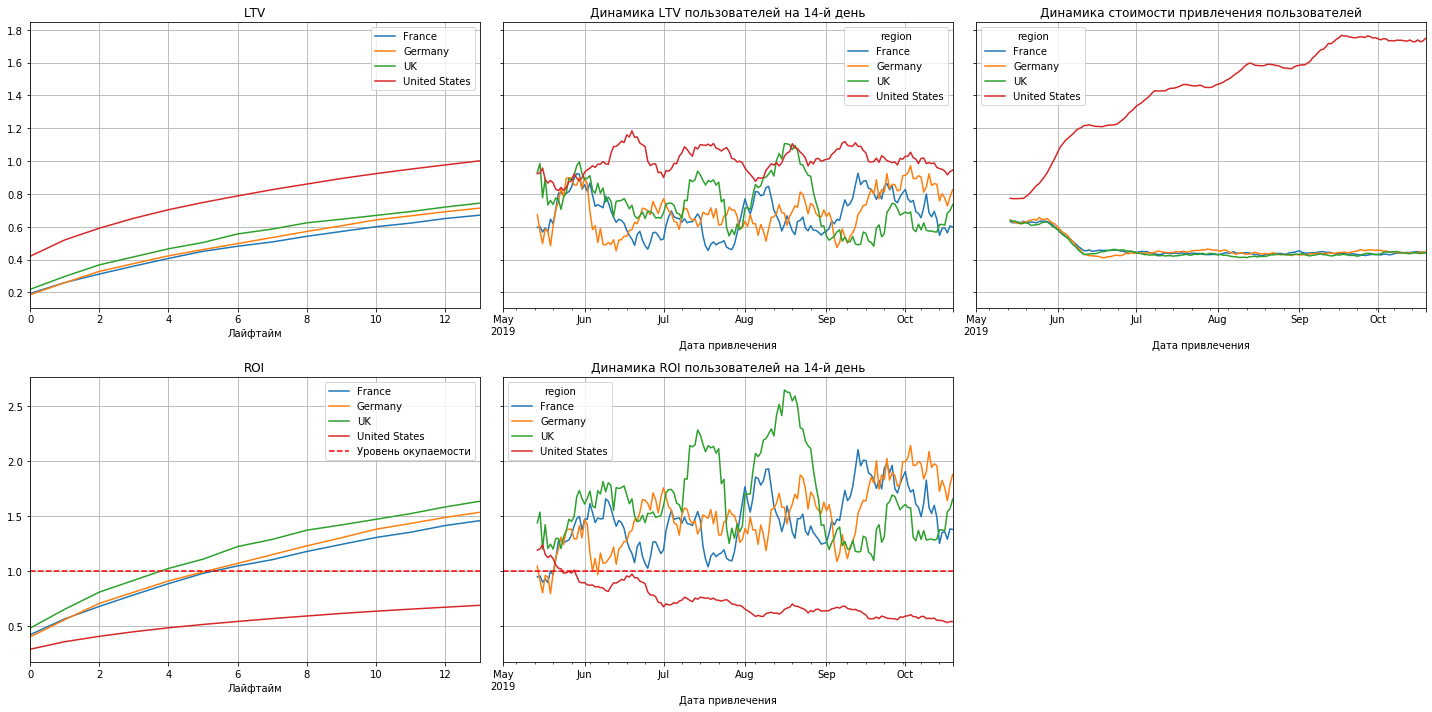

In [47]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_filtred, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Наконец мы смогли обнаружить проблему - реклама в US. Можно заметить, что:
* CAC в US растет ударными темпами, в то время как в остальных странах он стабилен. Траты на рекламу росли только в США.
* Все страны, кроме США, окупаются уже на 5-6 день. США окупается только на 70%.
* В целом динамика по странам, кроме США, хорошая. Проблемы возникают из-за возросшего рекламного бюджета.

Узнаем, в чём причина: в низкой конверсии или низком удержании.

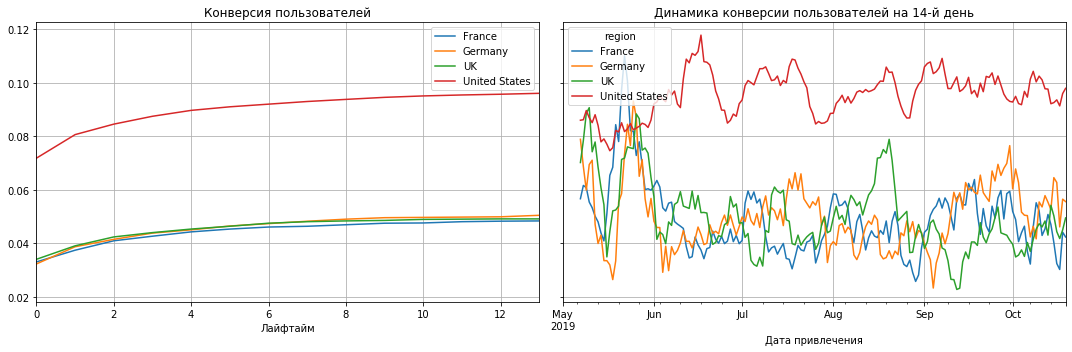

In [48]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_filtred, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Судя по графикам, пользователи из США конвертируются очень хорошо, лучше, чем из остальных стран.

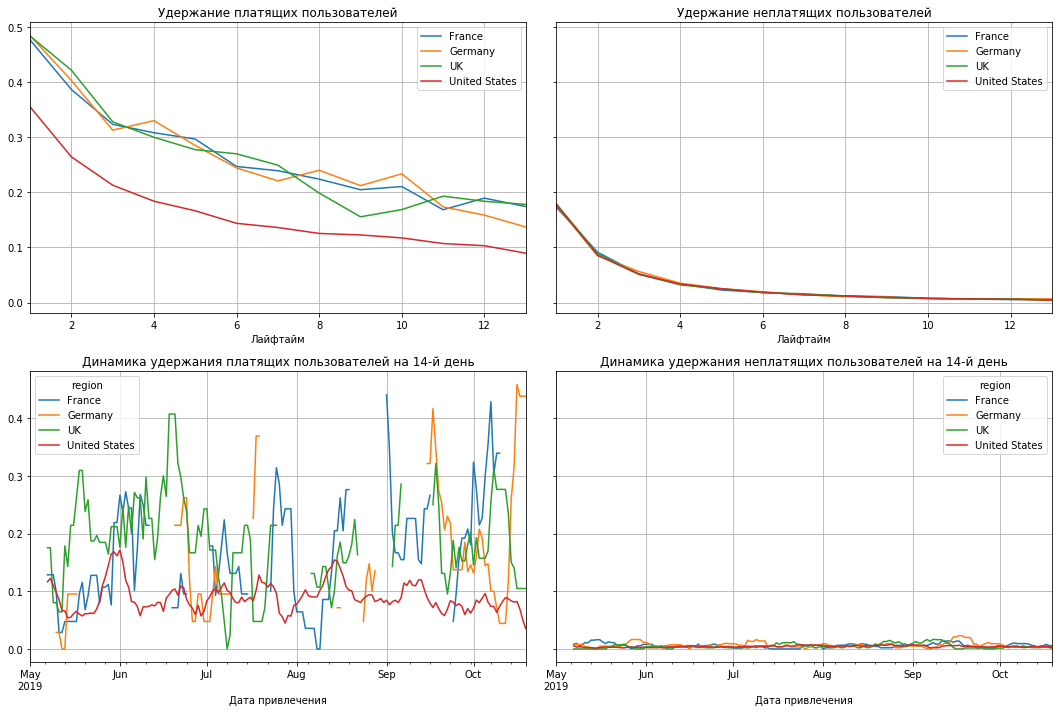

In [49]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_filtred, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

А вот удержание пользователей из США страдает - оно существенно ниже.

### Проанализируем окупаемость рекламы с разбивкой по рекламным каналам <a id='part_3.4'></a>

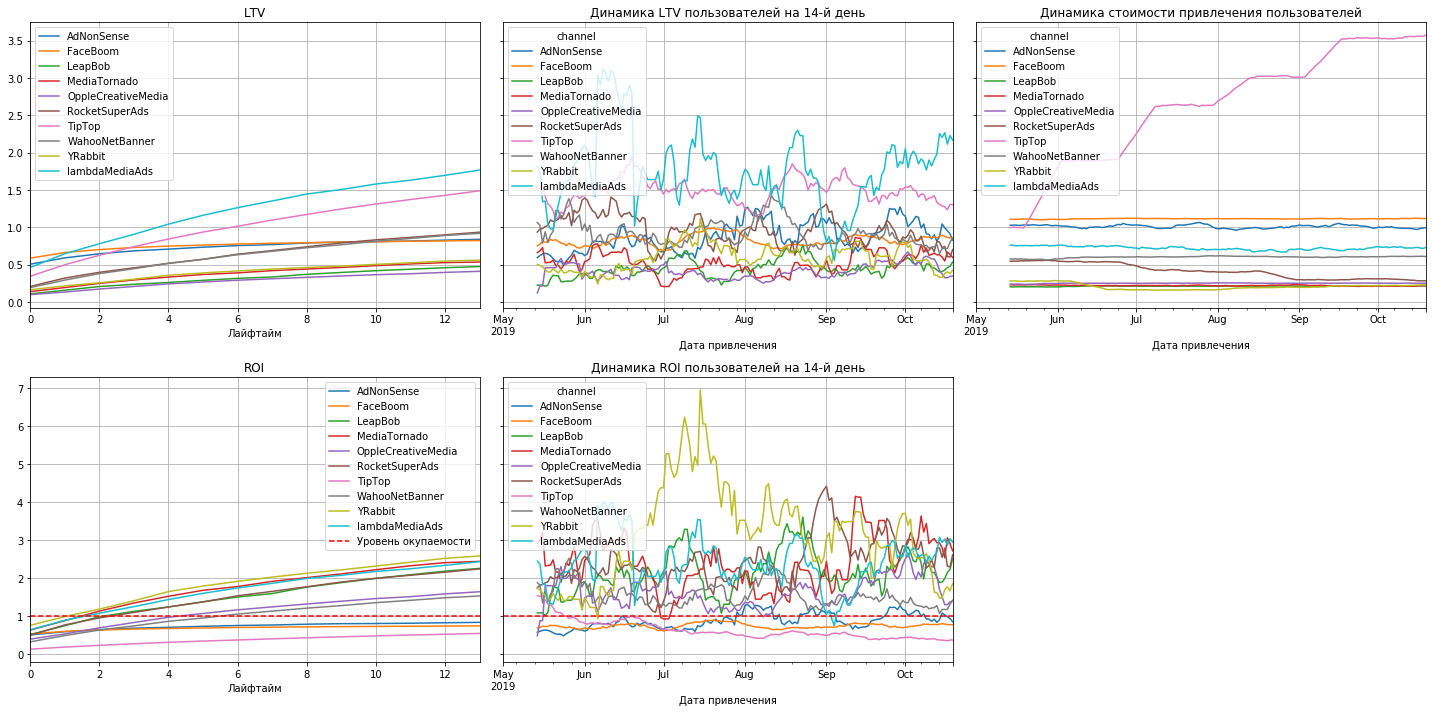

In [50]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_filtred, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Судя по графикам можно заметить следующее:
* Все возросшие расходы на рекламу идут в TipTop.
* TipTop, FaceBoom и AdNonSence не окупаются.
* "Среднячки" по окупаемости - WahooNetBanner и OppleCreativeMedia - они окупаются на 4-5 день.
* Остальные каналы привлечения окупаются просто отлично - буквально за 2-3 дня.

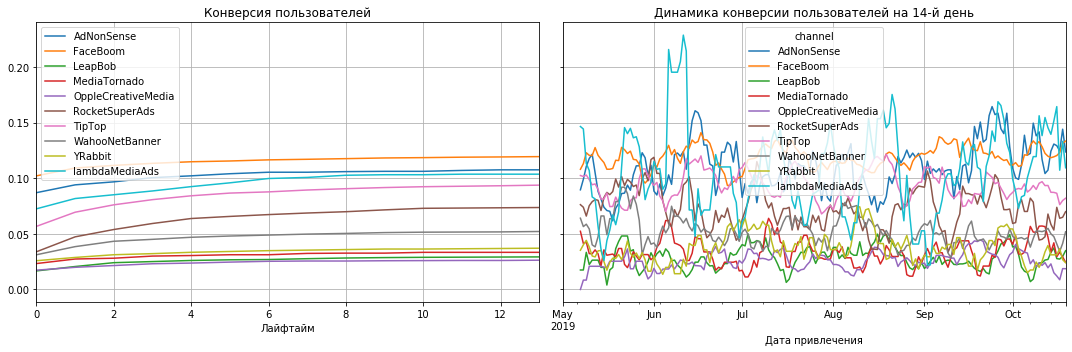

In [51]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_filtred, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

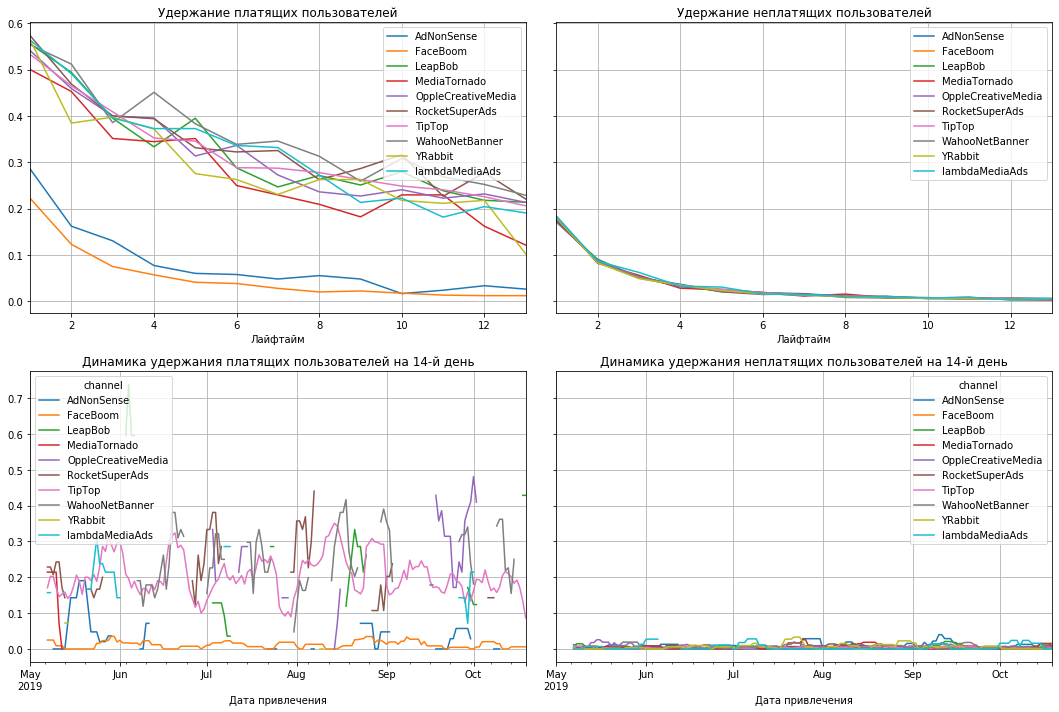

In [52]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_filtred, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Можем заметить, что удержание пользователей, привлеченных рекламой из FaceBoom и AdNonSense сильно ниже, чем у остальных рекламных источников.

По результатом анализа можно сделать следующие выводы:
* В целом реклама не окупается.
* Реклама пользователям iPhone и MAC к концу 14 дня окупается только на 90%.
* Проблемный регион - США, он окупается только на 80%. Там существенно растут расходы на рекламу, а удержание пользователей существенно ниже остальных стран.
* Расходы на рекламу растут из-за TipTop, это мешает окупаемости. За наблюдаемый период расходы выросли в 3,5 раза.
* Также не окупаются пользователи, привлеченные FaceBoom и AdNonSence. Проблемы связаны с тем, что пользователи, пришедшие из этого источника, плохо удерживаются. Возможно, это просто неподходящая целевая аудитория.

## Вывод
<a id='finish'></a>

[*Назад к оглавлению*](#content)


По результатам анализа можно сделать следующие выводы:
* Подавляющее большинство платящих пользователей приходит из США - 6902 клиента. Однако даже там часть платящих пользователей составляет лишь 6,9%.
* В девайсах лидером стал iPhone. Но тут разница между устройствами не так велика. Наибольшая доля платящих пользователей пользуются Mac и iPhone.
* По рекламным каналам уверенным лидером стал FaceBoom, там же и наибольший процент платящих пользователей - 12%.


* Среднее число пользователей в день - 1684, в неделю - 8354, в месяц - 28989.
* За наблюдаемый период число пользователей растет.
* Среднее число сессий в день - 1682, средняя длительность - 21 минута.

* В основном первая покупка совершается уже через 70 секунд после начала первой сессии.
* Среднее число покупок в день - 219, в неедлю - 1489, в месяц - 6702.


* Число покупок уверенно растет со временем.
* Средний чек в основном составляет 5,4 и меняется несущественно.
* За наблюдаемый период суммарно на маркетинг потратили 105 497 и во времени траты росли.
* В среднем привлечение одного пользователя обходилось в 0,7. Однако пользователи, привлеченные через рекламу в TipTop, FaceBoom и AdNonSense дороже, их привлечение стоило 2,8, 1,11 и 1,0 соответственно.


* Реклама не окупается. ROI в конце второй недели недели — достигае лишь 80%.
* Окупается только PC, на 12 день. Далее идет Android - к концу срока он окупается лишь на 90%. iPhone и MAC к концу 14 дня окупаются только на 70%.

* Компания увеличивает рекламный бюджета.
* Динамика окупаемости снижается - сказываются затраты на рекламу.
* Стоимость привлечения растет а всех устройствах. Сильнее всего на iPhone и MAC.
* Траты на рекламу росли только в США.

* Все страны, кроме США, окупаются уже на 5-6 день. США окупается только на 70%.

* В целом динамика по странам, кроме США, хорошая. Проблемы возникают из-за возросшего рекламного бюджета.
* Удержание пользователей из США страдает - оно существенно ниже остальных стран.
* Все возросшие расходы на рекламу идут в TipTop.
* TipTop, FaceBoom и AdNonSence не окупаются.
* "Среднячки" по окупаемости - WahooNetBanner и OppleCreativeMedia - они окупаются на 4-5 день. Остальные каналы привлечения окупаются просто отлично - буквально за 2-3 дня.

* Проблемы с FaceBoom и AdNonSence связаны с тем, что пользователи, пришедшие из этого источника, плохо удерживаются. Возможно, это просто неподходящая целевая аудитория.




Можно дать следующие рекомендации:
* Сделать больший акцент на рекламу в источниках с хорошей окупаемостью: LeapBob, MediaTornado, RocketSuperAds, YRabbit, lambdaMediaAds. Стоимость рекламы существенно ниже, чем у рекламных гигантов, и это позволяет ей лучше и быстрее окупаться.
* Снизить бюджет на рекламу в TipTop. Рассмотреть возможность урезать бюджет на рекламу этого источника, так как это не приносит меньше новых пользователей, чем FaceBoom, а стоимость привлеченного пользователя существенно (в 2,8 раза) больше.
* Посмотреть с чем связано низкое удержание пользователей, привлеченных через FaceBoom и AdNonSence. В целом, это хороший источник рекламы, который приносит наибольший процент клиентов и платящих пользователей.